# Image Segmentation with ENet
With the rise of AI and Machine Learning, new doors have been opened in the automotive industry for self driving vehicals. These vehicals use AI models to interperate their surroundings so that they can make the correct decisions to get you from A to B with everyone in one piece. A good, yet simple example of one of these models is ENet Cityscapes. This model does what is called __Image Segmentation__, which splits a photo in several regions based on what the model thinks they are.
Here is an example:

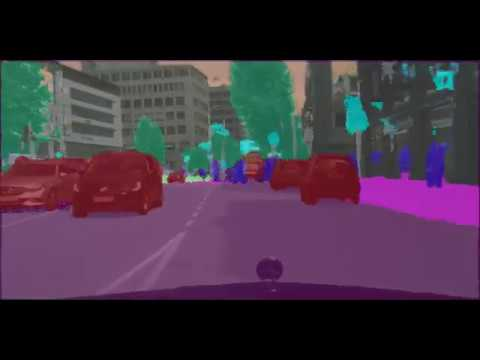

__Usefull Term Cheat Sheet:__
Here is a cheat sheet of some usefull terms that may pop up in this notebook. As always, feel free to ask me (Ben) any questions!

| Term | Description |
| --- | --- |
| DPU | Data Processing Unit |
| ENet | This is the segmentation model we are using! |
| Segmentation | Splitting a photo into different areas based on what is in them. |
| Overlay | Overlays are designes for the FPGA |
| Array | Another word for list. Multiple variables or items stored under one variable name. |

__Importing Libraries:__

In [1]:
# Lets import some libraries we will need later on:
import os                                               # The os library provides some functions for interacting with your operating system (your computer system)
import time                                             # The time library provides some time related functions like the wait() command
import numpy as np                                      # numpy or np is a library for processing numerical data. Its mainly just math stuff. 
import cv2                                              # cv2 is a library for image processing which we need later
from PIL import Image                                   # PIL Image adds some image processing tools too
import matplotlib.pyplot as plt                         # matplotlib.pyplot is a great tool for displaying data on graphs or other media 
%matplotlib inline
from pynq_dpu import DpuOverlay                         


#Now lets define some variables for later and get the DPU ready:
image_folder = 'img'                                    # Specifies which folder to look in for photos                                            

__Overlay Setup:__ 

Now lets define our overlay and load the Enet model onto it.

In [2]:
overlay = DpuOverlay("dpu.bit")                
overlay.load_model("pt_ENet.xmodel")

__Creating an image list:__

This cell creates a list of images we intend on using as inputs. It then prints how many images it finds.

In [3]:
# Here we are creating a list that contains all of the .jpeg photos in the image folder we specified earlier
original_images = [i for i in os.listdir(image_folder) if i.endswith("jpeg") or i.endswith("jpg")]
total_images = len(original_images)
print("Number of Photos:" + str(total_images))

Number of Photos:4


__Preprocessing Setup:__

Here we are going to define a few lists and a function that wwill be needed for preproccessing. The model cannot take an image as an imput directly, so these lists and functions are used to trun the photo into inputs the model can understand.

In [4]:
# The pallet list provides the colors to be used in our output photo later
pallete = [128, 64, 128, 244, 35, 232, 70, 70, 70, 102, 102, 156, 190, 153, 153, 153, 153, 153, 250, 170, 30,
           220, 220, 0, 107, 142, 35, 152, 251, 152, 70, 130, 180, 220, 20, 60, 255, 0, 0, 0, 0, 142, 0, 0, 70,
           0, 60, 100, 0, 80, 100, 0, 0, 230, 119, 11, 32 ]

# These are some preprocessing variables and functions that help the model interperate the input photo
# Dont worry if this looks like gibberish to you! This is beyond what you need to know for this camp.
MEANS = [.485, .456, .406]
STDS = [.229, .224, .225]

def preprocess_fn(image):
    image = image.astype(np.float32)
    image =  image / 255.0
    for j in range(3):
        image[:, :, j] -= MEANS[j]
    for j in range(3):
        image[:, :, j] /= STDS[j]
    return image

__Initializing the DPU:__
_I have no idea what this really does so someone please help me describe it. What is a runner?????_

In [5]:
dpu = overlay.runner

__Tensors:__

Tensors are how we pass information in and out of models. You can think of tensors as arrays of arrays of arrays or a "multidimentional array" if you want to sound cool. (Arrays are another word for lists!)

Here we are looking to find what the dimensions of the input and output tensors are so we know how to shape our data.

In [6]:
# Here we assign the input and output tensors to variables we can use later.
inputTensors = dpu.get_input_tensors()
outputTensors = dpu.get_output_tensors()

shapeIn = tuple(inputTensors[0].dims)   # (1, 512, 1024, 3)        
shapeOut = tuple(outputTensors[0].dims) # (1, 512, 1024, 19)
# outputSize = int(outputTensors[0].get_data_size() / shapeIn[0]) # While you dont need this, you can find out the size of your output too!

__Shaping the data:__

Here we want to shape our data to the tensor dimentions we found in the last cell. We do this through a library called numpy which is really good for numerical computing.

In [7]:
input_data = [np.empty(shapeIn, dtype=np.float32, order="C")]
output_data = [np.empty(shapeOut, dtype=np.float32, order="C")]
image = input_data[0]

__Where all the fun happens!__

Here we define our run function which takes our image and segments it. This uses all of the bits and pieces we defined earlier!

In [8]:
def run(image_index, display=False):
    # Read input image
    input_image = cv2.imread(os.path.join(image_folder, original_images[image_index]))
    
    # Pre-processing
    resized = cv2.resize(input_image,(1024,512))
    preprocessed = preprocess_fn(resized)
    
    # Fetch data to DPU and trigger it
    image[0,...] = preprocessed.reshape(shapeIn[1:])
    job_id = dpu.execute_async(input_data, output_data)
    dpu.wait(job_id)                                        # TODO: what does the wait function do?
    
    # Retrieve output data
    classMap_numpy = np.argmax(output_data[0][0], axis=-1).astype(np.uint8)
    classMap_numpy = Image.fromarray(classMap_numpy)
    classMap_numpy_color = classMap_numpy.copy()
    classMap_numpy_color.putpalette(pallete)
    if display:
        _, ax = plt.subplots(1) # Display segmented Image
        _ = ax.imshow(classMap_numpy_color)
        
        
        display_image = cv2.imread(os.path.join(    # Display original image
            image_folder, original_images[image_index]))
        _, ax = plt.subplots(1)
        _ = ax.imshow(cv2.cvtColor(display_image, cv2.COLOR_BGR2RGB))

__Go time!__

Lets finally run this thing by passing in one of our photos from the origional_images list!

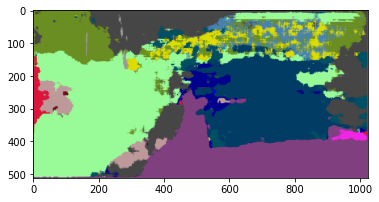

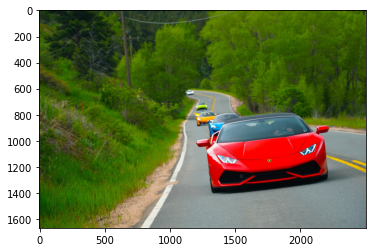

In [9]:
run(0, display=True) 

__But Wait! There's More!__

We can use a simple for loop to do this for all of the images we found earlier.

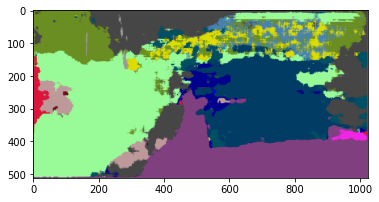

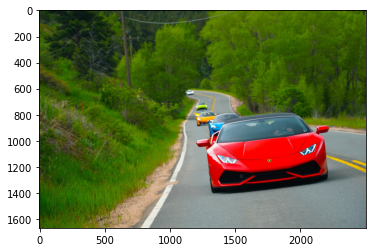

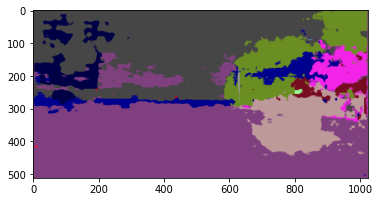

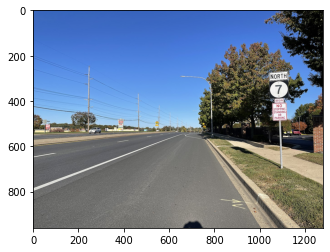

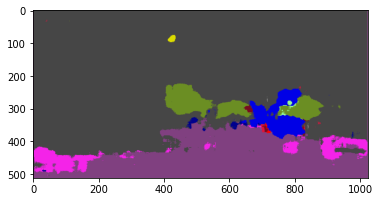

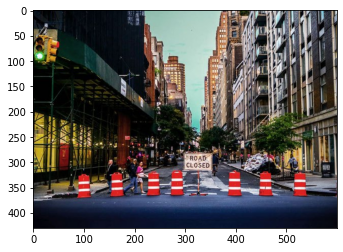

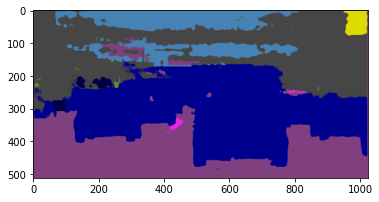

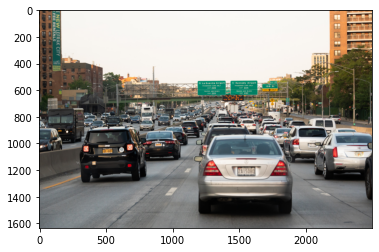

In [10]:
for img in original_images:
    run(original_images.index(img), display=True) 